![](https://i.imgur.com/o0xPvMY.png)

In [1]:
!pip install textstat

import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import textstat
import wandb
import spacy
nlp = spacy.load('en_core_web_sm')

from termcolor import colored
from wordcloud import WordCloud,STOPWORDS
from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 101 kB 3.3 MB/s            
     |████████████████████████████████| 2.0 MB 29.4 MB/s            


<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67">

I will be integrating W&B for visualizations and logging artifacts!

> [NBME - Score Clinical Patient Notes](https://wandb.ai/ruchi798/nbme?workspace=user-ruchi798)🏋️‍♀️
> 
> - To get the API key, an account is to be created on the [website](https://wandb.ai/home) first.
> - Next, use secrets to use API Keys more securely 🤫

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("api_key")

CONFIG = {'competition': 'nbme', '_wandb_kernel': 'ruch'}

os.environ["WANDB_SILENT"] = "true"

In [3]:
! wandb login $api_key

In [4]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [5]:
BASE_PATH = "../input/nbme-score-clinical-patient-notes/"
features_df = pd.read_csv(BASE_PATH + "features.csv")
patient_notes_df = pd.read_csv(BASE_PATH + "patient_notes.csv")
train_df = pd.read_csv(BASE_PATH + "train.csv")
test_df = pd.read_csv(BASE_PATH + "test.csv")
submission_df = pd.read_csv(BASE_PATH + "sample_submission.csv")

```features.csv```

A rubric describes the key concepts relevant to each case.

* feature_num - A unique identifier for each feature.
* case_num - A unique identifier for each case.
* feature_text - A description of the feature.

In [6]:
features_df.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [7]:
features_df.nunique()

feature_num     143
case_num         10
feature_text    131
dtype: int64

```patient_notes.csv``` 

Text detailing important information related by the patient during the encounter (physical exam and interview)

* pn_num - A unique identifier for each patient note.
* case_num - A unique identifier for the clinical case a patient note represents.
* pn_history - The text of the encounter as recorded by the test taker.

In [8]:
patient_notes_df.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [9]:
patient_notes_df.nunique()

pn_num        42146
case_num         10
pn_history    42146
dtype: int64

```train.csv```
* id - Unique identifier for each patient note / feature pair.
* pn_num - The patient note annotated in this row.
* feature_num - The feature annotated in this row.
* case_num - The case to which this patient note belongs.
* annotation - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
* location - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

In [10]:
train_df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [11]:
train_df.nunique()

id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64

<center><img src="https://raw.githubusercontent.com/github/explore/8cf1837393d83900e767cc895dcc814d053e2ffe/topics/spacy/spacy.png"></center>

#### 📝 Using spaCy for visualizing annotations, NER and POS tagging! 

# 👀 Annotations, NER & POS

In [12]:
def patient_data(pn_num):
    subset = train_df[train_df['pn_num'] == pn_num]
    
    features_lst = subset['feature_num'].tolist()
    annotations_lst = subset['annotation'].tolist()
    
    subset_c = subset.copy()
    subset_c['location'] = subset_c['location'].apply(eval)
    subset_c['annotation'] = subset_c['annotation'].apply(eval)
    locations  = subset_c["location"]
    annotations = subset_c["annotation"]
    
    print("*"*80)
    print(colored("Patient Number: " + str(pn_num), 'green'))
    patient_history = patient_notes_df[patient_notes_df['pn_num']==pn_num]['pn_history'].item()
    
    print(colored("\nAnnotated Patient History", 'green'))
    
    ents = []
    for location in locations:
        for i in range(len(location)):
            for loc in location:
                val = loc.split()
                ents.append({
                'start': int(val[0]), 
                'end' :  int(val[1]),
                'label' : "Annotation"
                })
    ents = sorted(ents, key = lambda i: i['start'])

    doc = {
        'text' : patient_history,
        'ents' : ents
    }
    colors = {"Annotation" :"linear-gradient(to right, #2980b9, #6dd5fa, #ffffff);" } 
    options = {"colors": colors}
    spacy.displacy.render(doc, style='ent', options = options , manual=True, jupyter=True);
    
    print(colored("\nVisualizing NER", 'green'))
    doc = nlp(patient_history)
    displacy.render(doc, style='ent', jupyter = True)
    
    print(colored("\nVisualizing POS tagging", 'green'))
    sentences = sent_tokenize(patient_history)
    word_count = lambda sentence: len(word_tokenize(sentence))
    pos_text = max(sentences, key=word_count)  
    doc = nlp(pos_text)
    displacy.render(doc, style="dep")

    print(colored("\nFeatures", 'green'))
    for feature_num in features_lst:
        feature = features_df[features_df['feature_num'] == feature_num]['feature_text'][feature_num]
        print(colored(feature, 'blue'))
        
patient_data(16)
patient_data(46)
patient_data(100)

********************************************************************************
Patient Number: 16

Annotated Patient History



Visualizing NER



Visualizing POS tagging



Features
Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male
********************************************************************************
Patient Number: 46

Annotated Patient History



Visualizing NER



Visualizing POS tagging



Features
Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male
********************************************************************************
Patient Number: 100

Annotated Patient History



Visualizing NER



Visualizing POS tagging



Features
Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male


# ☁️ WordClouds

annotation


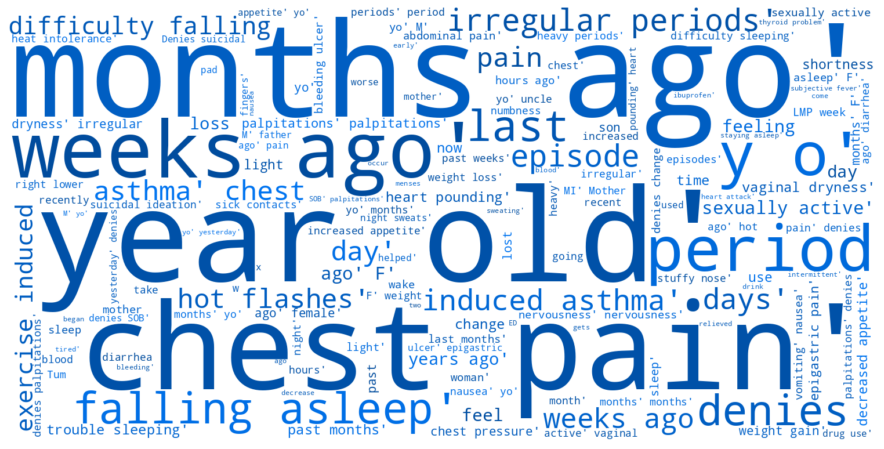

In [13]:
# color function for the wordcloud
def color_wc(word=None,font_size=None,position=None, orientation=None,font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(80, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def create_wordcloud(df, col):
    print(colored(col, 'green'))
    
    run = wandb.init(project='nbme', job_type='image-visualization',name='wordCloud')
    
    fig = plt.gcf()
    fig.set_size_inches(16, 8)
    wc = WordCloud(stopwords=STOPWORDS,background_color="white", contour_width=2, contour_color='blue',width=1500, height=750,color_func=color_wc,max_words=150, max_font_size=256,random_state=42)
    wc.generate(' '.join(df[col]))
    fig = plt.imshow(wc, interpolation="bilinear")
    fig = plt.axis('off')
    
    wc_name =  "wordcloud_" + col
    wandb.log({wc_name: [wandb.Image(plt, caption="Wordcloud")]})
    run.finish()

create_wordcloud(train_df, 'annotation')

feature_text


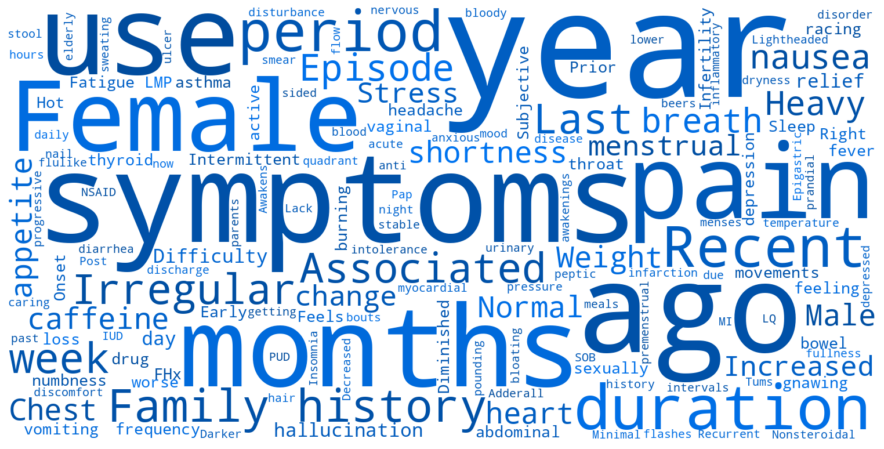

In [14]:
create_wordcloud(features_df, 'feature_text')

pn_history


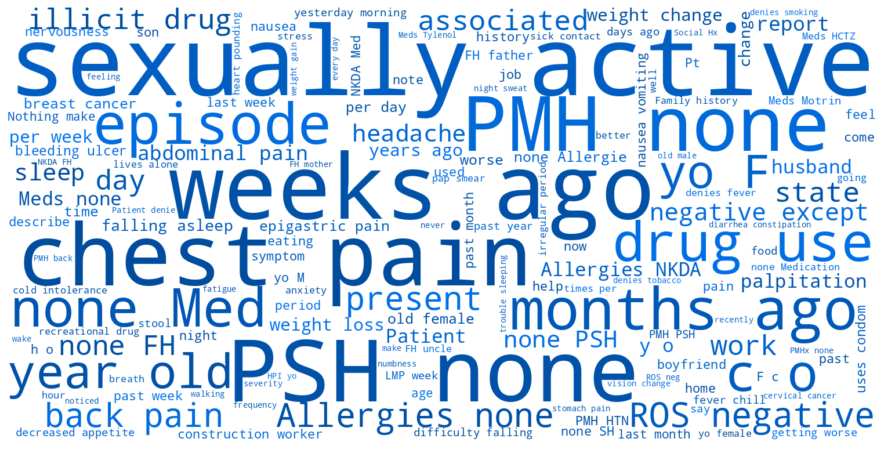

In [15]:
create_wordcloud(patient_notes_df, 'pn_history')

# 📊 Text properties 

annotation


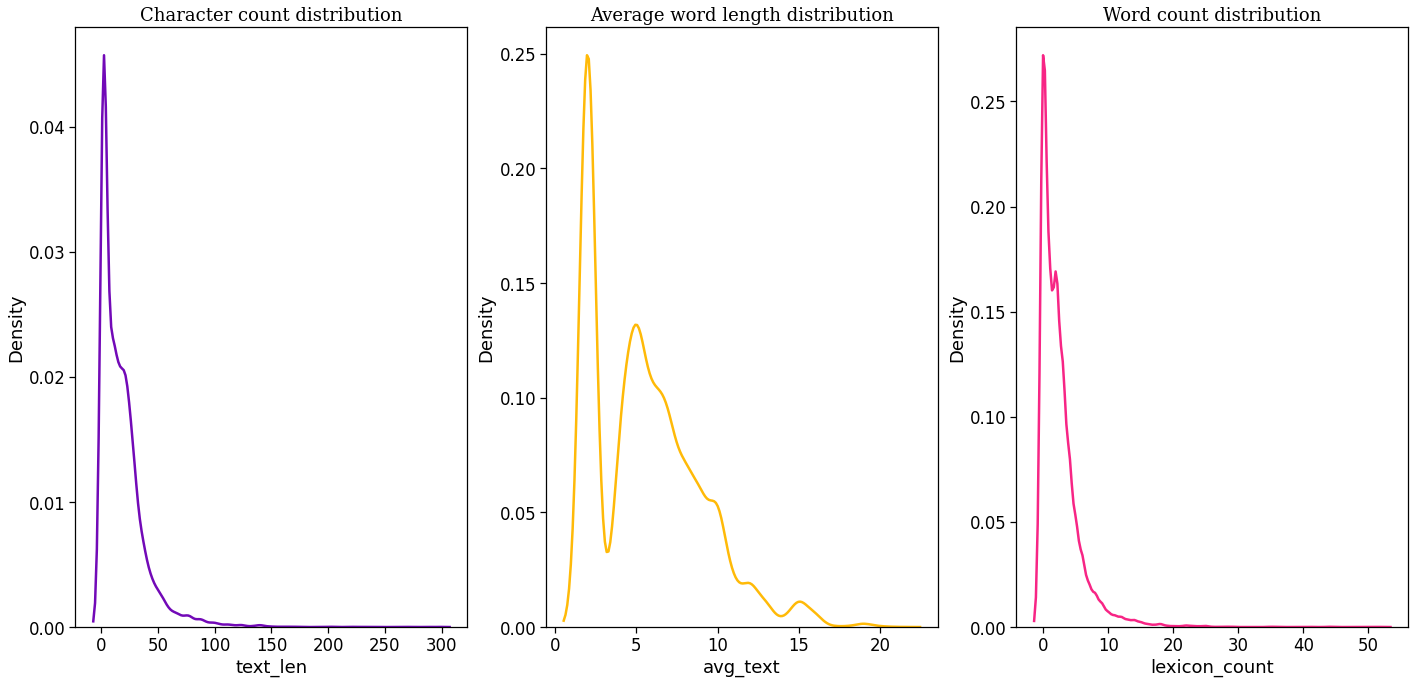

feature_text


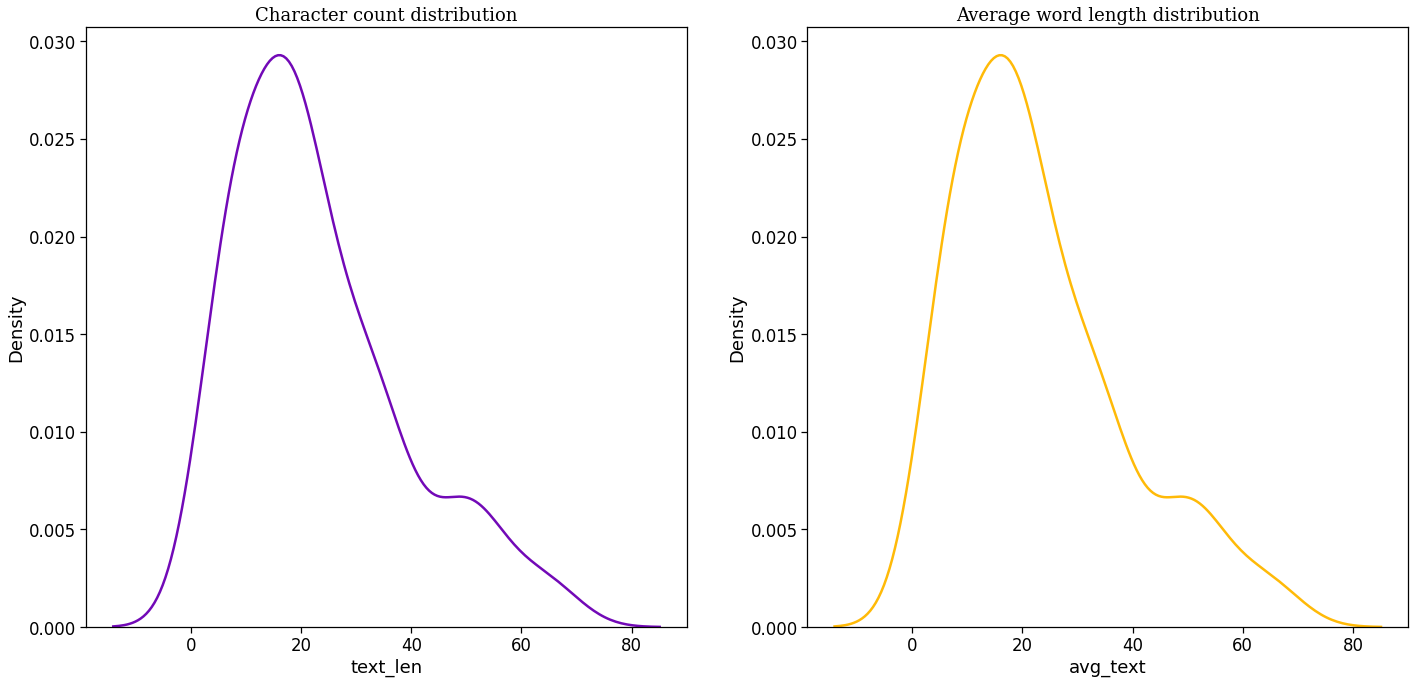

pn_history


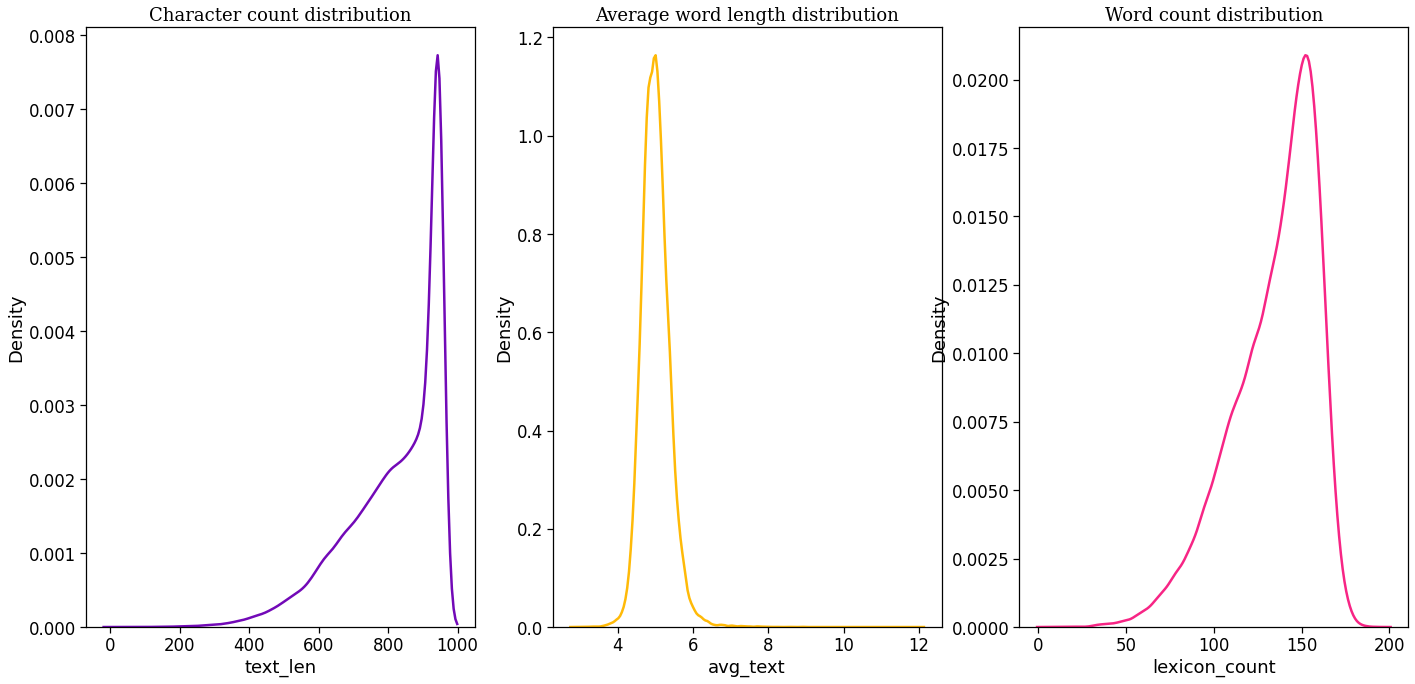

In [16]:
#====== Function to plot wandb histogram ======
def plot_wb_hist(df,name,title):
    run = wandb.init(project='nbme', job_type='image-visualization',name=name)

    dt = [[x] for x in df[name]]
    table = wandb.Table(data=dt, columns=[name])
    wandb.log({title : wandb.plot.histogram(table, name, title=title)})

    run.finish()
    
def avg_word_len(df):
    df = df.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return df

def plot_distribution(text_props, num_sub):
    fig, ax = plt.subplots(1,num_sub,figsize=(20,10))
    sns.kdeplot(data=text_props, x="text_len",color="#7209B7",ax=ax[0])
    ax[0].set_title("Character count distribution",font="Serif")
    
    sns.kdeplot(data=text_props, x="avg_text",color="#FFBA08",ax=ax[1])
    ax[1].set_title("Average word length distribution",font="Serif")
    
    if num_sub != 2:
        sns.kdeplot(data=text_props, x="lexicon_count",color="#F72585",ax=ax[2])
        ax[2].set_title("Word count distribution",font="Serif")
        
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)
    plt.show()
    
def text_properties(df, col, num_sub):
    text_props = df.copy()
    text_len = df[col].str.len()
    avg_text = avg_word_len(df[col])
    lexicon_count = []
    sentence_count = []
    for i in range(len(df)):
        lc = textstat.lexicon_count(df[col][i])
        lexicon_count.append(lc)

    text_props['text_len'] = text_len
    text_props['lexicon_count'] = lexicon_count
    text_props['avg_text'] = avg_text
    
    print(colored(col, 'green'))
    plot_distribution(text_props, num_sub)
    return text_props
    
text_props = text_properties(train_df, 'annotation',3)
plot_wb_hist(text_props,"text_len","annotation: Character Count Distribution")
plot_wb_hist(text_props,"lexicon_count","annotation : Word Count Distribution")
plot_wb_hist(text_props,"avg_text","annotation : Average Word Length Distribution")

text_props = text_properties(features_df, 'feature_text',2)
plot_wb_hist(text_props,"text_len","feature_text : Character Count Distribution")
plot_wb_hist(text_props,"avg_text","feature_text : Average Word Length Distribution")

text_props = text_properties(patient_notes_df, 'pn_history',3)
plot_wb_hist(text_props,"text_len","pn_history : Character Count Distribution")
plot_wb_hist(text_props,"lexicon_count","pn_history : Word Count Distribution")
plot_wb_hist(text_props,"avg_text","pn_history : Average Word Length Distribution")

# 🔤 Abbreviations used 

In [17]:
pl = patient_notes_df['pn_history'].tolist()
pl1 = [i.split('\n', 1)[0] for i in pl]

pattern = re.compile('(.*?)\:')
vals = []
for item in range(len(pl1)):
    val = pattern.findall(pl1[item])
    if val:
        if(len(val[0]) < 10):
            vals.append(val[0])

print(set(vals))

{'headache', 'HPIx', '- HPI ', 'complaint', 'PMH', 'Gen', '- HPI', 'cc/HPI', 'HxPC', 'HP', 'HPI', 'cc ', 'CO', 'Px', 'C.C', 'pmh', 'PMI', 'Name/Age', 'HX', 'Hpi', 'source', 'Complaint', 'HPIl', 'hpi ', 'HIi', 'Data', 'hpi', 'ID / CC', 'c/c', 'CC ', 'GA', 'Pt', 'ID+CC', 'ccc', 'HPI/CC', 'Identity', 'hopi', 'C', 'History', 'HIstory', 'C.C.', 'C/C', 'CC/HPI', 'Patient', 'ID', 'HPHI', 'Cc', '-CC', 'HOPC', 'ID/HPI', 'HISTORY ', 'HPIN ', 'HDI', 'PMHx', 'C/c', 'HxPI', 'ID/CC', 'Hx', 'CC/ID', 'PC', 'HIPI', 'IDCC', 'cc', '-HPI', 'HOPI', 'HPC', 'CC', 'HOI', 'C/O', '45yo F CC', 'HPT', 'PT', 'PHI', 'c/o', 'Name', 'VS', 'Profile', 'HI', 'PCx', '35yo M CC', 'PI', 'HpI', 'HPI ', '26f CC', '35yof cc', 'co', 'HPi', 'HIP'}


Here's a snapshot of my [project](https://wandb.ai/ruchi798/nbme?workspace=user-ruchi798) ⬇️

![](https://i.imgur.com/5we1jz6.png)
